# Tugas Workshop PKAC

Amelia Syahla Aurellia Sambudi
23/512057/PA/21866

## IMPORT LIBRARY

Pada bagian ini akan diimpor modul yang akan digunakan dalam projek, sebagai berikut:
1. OS -> untuk akses file lokal dari komputer
2. cv2 -> untuk image processing
3. numpy -> untuk perhitungan matematis
4. matplotlib.pyplot -> untuk visualisasi dari citra

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

## LOAD DATASET

Sebelum gambar di proses, kita butuh load dataset menggunakan fungsi 

In [16]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print('Error: Could not load image.')
        print(image_path)
        return None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

In [20]:
sample_image, sample_image_grey = load_image('images/Amelia_Syahla/amel16.jpg')

In [21]:
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

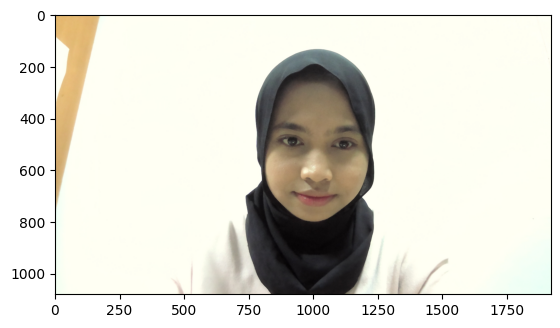

In [22]:
plt.imshow(sample_image_rgb)

In [23]:
dataset_dir = 'images'
images = []
labels = []
for root, dirs, files in os.walk(dataset_dir):
    if len(files) == 0:
        continue
    for f in files:
        _, image_gray = load_image(os.path.join(root, f))
        if image_gray is None:
            continue
        images.append(image_gray)
        labels.append(os.path.basename(root))

In [24]:
len(labels)

140

## FACE DETECTION

### Load dan menggunakan Haar Cascade Model

In [25]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [26]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
    faces = face_cascade.detectMultiScale(
        image_gray,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=min_size
    )
    return faces

In [27]:
sample_faces = detect_faces(sample_image_grey, min_size=(50, 50))

### Cropping Faces

In [28]:
def crop_faces(image_gray, faces, return_all=False):
    cropped_faces = []
    selected_faces = []
    if len(faces) > 0:
        if return_all:
            for x, y, w, h in faces:
                selected_faces.append((x, y, w, h))
                cropped_faces.append(image_gray[y:y+h, x:x+w])
            return cropped_faces, selected_faces
        else:
            x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
            selected_faces.append((x, y, w, h))
            cropped_faces.append(image_gray[y:y+h, x:x+w])
            return cropped_faces, selected_faces
    return cropped_faces, selected_faces

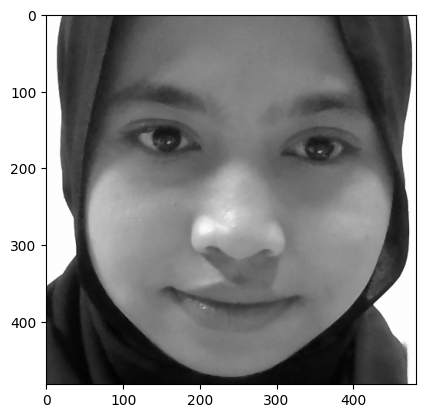

In [29]:
cropped_faces, _ = crop_faces(sample_image_grey, sample_faces)
plt.imshow(cropped_faces[0], cmap='gray')

## Face Recognition - Eigenface

### Resize and Flatten Faces

In [30]:
face_size = (128, 128)
def resize_and_flatten(face):
    face_resized = cv2.resize(face, face_size)
    face_flattened = face_resized.flatten()  #area menjadi 1 dimensi misal array 2 dimensi menjadi array 1 dimensi
    return face_flattened

### Prepare Training and Testing Data

In [31]:
X = []
y = []

for image, label in zip(images, labels):
    faces = detect_faces(image)  # detect informasi x w y h
    cropped_faces, _ = crop_faces(image, faces)
    if len(cropped_faces) > 0:  # klo tdk terdeteksi wajah ga dimasukin
        face_flattened = resize_and_flatten(cropped_faces[0])
        X.append(face_flattened)
        y.append(label)

X = np.array(X)  # ubah tipe biar lebih cepat
y = np.array(y)

In [32]:
len(X)

140

In [33]:
X.shape

(140, 16384)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=28, stratify=y)

### Mean Centering

In [35]:
#Mean centering (data dikurangi dgn rata ratanya, mirip normalisasi)
from sklearn.base import BaseEstimator, TransformerMixin

class MeanCentering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean_face = np.mean(X, axis=0)
        return self
    
    def transform(self, X):
        return X - self.mean_face

### Extract Eigenfaces and Build Classifier

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('centering', MeanCentering()),
    ('pca', PCA(svd_solver='randomized', whiten=True, #dimensi reduksi
                random_state=28)),
    ('svc', SVC(kernel='linear', random_state=28)) #svm classifier
    ])

### Train and Evaluate the Model

In [37]:
from sklearn.metrics import classification_report

pipe.fit(X_train, y_train) #model mentraining data train

y_pred = pipe.predict(X_test) #evaluate model dengan data set, 12 gambar testing
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

  Amelia_Syahla       0.83      0.83      0.83         6
  George_W_Bush       1.00      1.00      1.00         6
      Geraldine       1.00      0.83      0.91         6
     Laura_Bush       0.86      1.00      0.92         6
    NIKI_Artist       0.83      0.83      0.83         6
Serena_Williams       1.00      0.67      0.80         6
 Vladimir_Putin       0.75      1.00      0.86         6

       accuracy                           0.88        42
      macro avg       0.90      0.88      0.88        42
   weighted avg       0.90      0.88      0.88        42



### Visualizing Eigenfaces

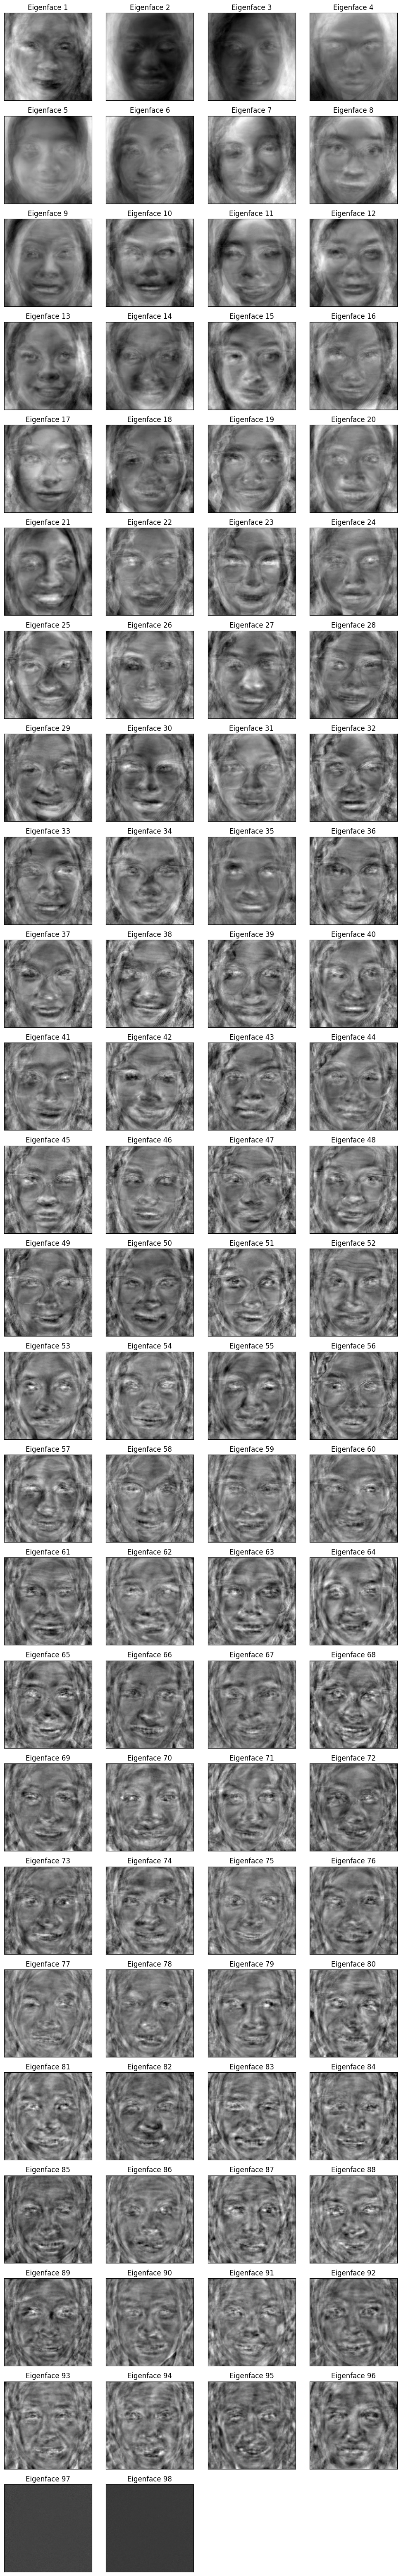

In [38]:
n_components = len(pipe[1].components_)
ncol = 4
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5*nrow), subplot_kw={'xticks':[], 'yticks':[]})

eigenfaces = pipe[1].components_.reshape((n_components, X_train.shape[1]))

if nrow == 1 and ncol == 1:
    axes = np.array([axes])
elif nrow == 1 or ncol == 1:
    axes = axes.reshape(-1)

# Plot each eigenface
for i, ax in enumerate(axes.flat):
    if i < n_components:  # Only plot if we have an eigenface available
        ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
        ax.set_title(f'Eigenface {i+1}')
    else:
        # Hide unused subplots
        fig.delaxes(ax)
        
plt.tight_layout()
plt.show()

### Save the Model Pipeline

In [39]:
import pickle
#simpen model ke lokal
with open('eigenface_pipeline.pkl', 'wb') as f:
    pickle.dump(pipe, f)

### Combine All Methods

In [40]:
def get_eigenface_score(X): #score, dia lebih mirip ke wajah siapa trs di score
    X_pca = pipe[:2].transform(X)
    eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
    return eigenface_scores

In [41]:
def eigenface_prediction(image_gray):
    faces = detect_faces(image_gray)
    cropped_faces, selected_faces = crop_faces(image_gray, faces)
    
    if len(cropped_faces) == 0:
        return 'No face detected.'
    
    X_face = []
    for face in cropped_faces:
        face_flattened = resize_and_flatten(face)
        X_face.append(face_flattened)
        X_face = np.array(X_face)
        labels = pipe.predict(X_face)
        scores = get_eigenface_score(X_face)
        
        return scores, labels, selected_faces

In [42]:
sample_scores, sample_labels, sample_faces = eigenface_prediction(sample_image_grey)

In [43]:
sample_scores

array([6.28874884])

In [44]:
sample_labels

array(['Amelia_Syahla'], dtype='<U15')

In [45]:
sample_faces

[(np.int32(760), np.int32(328), np.int32(482), np.int32(482))]

### Visualize Result

In [46]:
def draw_text(image, label, score, font=cv2.FONT_HERSHEY_SIMPLEX,
    pos=(0, 0),
    font_scale=0.6,
    font_thickness=2,
    text_color=(0, 0, 0),
    text_color_bg=(0, 255, 0)
    ):
    x, y = pos
    score_text = f'Score: {score:.2f}'
    (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale,
    font_thickness)
    (w2, h2), _ = cv2.getTextSize(label, font, font_scale,
    font_thickness)
    cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y), text_color_bg, -1)
    cv2.putText(image, label, (x+10, y-10), font, font_scale, text_color, font_thickness)
    cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale,
    text_color, font_thickness)

In [47]:
def draw_result(image, scores, labels, coords):
    result_image = image.copy()
    for (x, y, w, h), label, score in zip(coords, labels, scores):
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0),2)
        draw_text(result_image, label, score, pos=(x, y))
        return result_image

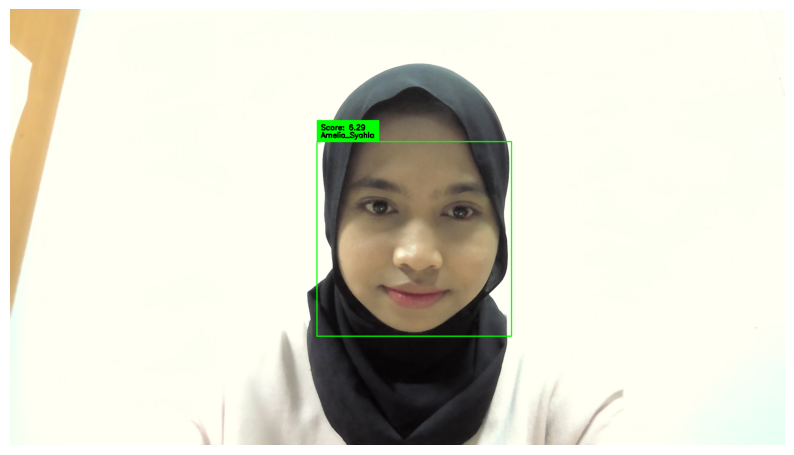

In [48]:
import matplotlib.pyplot as plt

result_image = draw_result(sample_image, sample_scores, sample_labels, sample_faces)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.axis('off')
plt.show()

# APPLY THE FACE RECOGNITION ON VIDEO MP4 BECAUSE MY WEBCAM NOT AVAILABLE

In [49]:
import cv2

video_path = 'Test2.mp4'

def test_video(video_path, window_name='Face Recognition', width=800, height=600):
    # Inisialisasi video capture
    cap = cv2.VideoCapture(video_path)
    
    # Buat jendela yang bisa di-resize
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    # Set ukuran jendela
    cv2.resizeWindow(window_name, width, height)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Konversi ke grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Deteksi wajah dan prediksi menggunakan Eigenface
        result = eigenface_prediction(frame_gray)
        if isinstance(result, str):
            # Jika tidak terdeteksi wajah
            print(result)
            continue
        
        scores, labels, faces = result
        
        # Gambar hasil deteksi dan prediksi
        result_frame = draw_result(frame, scores, labels, faces)
        
        # Tampilkan di window yang sudah di-resize
        cv2.imshow(window_name, result_frame)
        
        # Keluar jika tombol 'q' ditekan
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

# Panggil dengan ukuran jendela yang diinginkan, misalnya 1024×768
test_video(video_path, width=1080, height=720)